# Calculate angles and velocities 

Eucledian_distance.rename(columns={"Continuous_Time": "time", 
                                   "playerBodyPosition.x": "xcoord_orig", 
                                   "playerBodyPosition.z": "zcoord_orig", 
                                   "playerBodyPosition.y": "ycoord_orig", 
                                   "hitPointOnObject_x": "xhpoo", 
                                   "hitPointOnObject_y": "yhpoo", 
                                   "hitPointOnObject_z": "zhpoo" })

In [1]:
import pandas as pd
import numpy as np 
import math 
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt 

# Starts Here


In [2]:
One_participant = pd.read_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/04_Interpolated/4917_2.csv")

In [3]:
for_eye = One_participant.copy()
time = for_eye["timeStampDataPointEnd"].tolist()

# get individual coordinates
 # position
Xcorr_position = for_eye["playerBodyPosition.x"].tolist()
Ycorr_position = for_eye["playerBodyPosition.y"].tolist()
Zcorr_position = for_eye["playerBodyPosition.z"].tolist()
subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

# hpoo
hpooX = for_eye["hitPointOnObject_x"].tolist()
hpooY = for_eye["hitPointOnObject_y"].tolist()
hpooZ = for_eye["hitPointOnObject_z"].tolist()
hpoo = list(zip(hpooX, hpooY, hpooZ))

# v_gaze_vec: get difference in hpoo
v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

# get difference in time:
ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
# display(np.linalg.norm(gaze_vec[1]))

# v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
# z1 = (<v_gaze_vec(t), gaze_vec(t)>)
z1 = [np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
        for t in range(len(v_vX))]

# z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

# ||v_gaze_vec(t) - z||
v_gaze_inplane = [np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
        for t in range(len(v_gaze_vec))
                 ]
# w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

# sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
sub_hpoo = [np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
        for t in range(len(hpoo))]

# arctan2(v_gaze_inplane, sub_hpoo)
w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

###Atention HERE 
# turn angle of radians into degrees
#w_gaze = [np.rad2deg(value) for value in w_gaze]
w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
# save df
for_eye["combined_vel"] = w_gaze

In [4]:
# Function: calculate MAD saccade
def at_mad(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    while True:
        # take th_0
        threshs.append(th_0)
        # get all angles smaller than this
        angular_vel = angular_vel[angular_vel < th_0]

        # MAD:
        # take the median of all angles smaller than th_0
        median = np.median(angular_vel)
        # substract the median value
        diff = np.sqrt((angular_vel - median) ** 2)
        # get the median of these values
        med_abs_deviation = np.median(diff)

        # calcualte the next threshold with the median
        # 1.486 used when assuming a normal distribution
        th_1 = median + 3 * 1.486 * med_abs_deviation
        # if the thresholds are too different, redo the while loop
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        # else, set the final threshold to the current one, break the while loop and return values
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs

# Calculate the threshold acorss the between calibration intervals

# determining a critical velocity on a median-filtered (median filter length) time series comprising
# the full duration of a recording. All such periods of consecutive above-threshold velocities are
# weighted by the sum of these velocities. Boundaries of time series chunks are determined by selecting
# such events sequentially (starting with the largest sums) until a maximum average frequency across
# the whole time series is reached resulting chunks represent data intervals between saccades of maximum
# magnitude in the respective data.


# get time
time = for_eye["timeStampDataPointEnd"].tolist()

int_data_all = None

# define the intervals to investigate 
start_int = [time[0]]
end_int = []
for cnt, t in enumerate(time[1:]):
    if t - time[cnt] > 0.5:
        start_int = start_int + [t]
        end_int = end_int + [time[cnt]]
end_int = end_int + [time[-1]]

# go through the interval and calculate the theshold etc.:
for interv in range(len(start_int)):
    #time = for_eye["time"].tolist()[start_int[interv]:]
    fe = for_eye[(for_eye['timeStampDataPointEnd'] >= start_int[interv]) & (for_eye['timeStampDataPointEnd'] <= end_int[interv])]
    time = for_eye["timeStampDataPointEnd"].tolist()

    # run MAD saccade on the entire data
    saccade_th, thres = at_mad(fe["combined_vel"])
    # detect all periods above the calculated threshold
    fast_sacc = [
        ti if ti >= saccade_th else np.nan for ti in fe["combined_vel"].tolist()
    ]  

    start = [time[0]]  # onset time
    start_idx = [0]  # onset idx
    end = []  # offset time
    end_idx = []  # offset index
    total_vels = []  # save the velocities to sort the fast_sacc

    # to add and update for each interval
    starts = []  # save the indicies in
    vels = []  # save the velocities in
    cnt = True  # every time it will be set to true, add the velocity


    for v in range(1,(len(fast_sacc) - 1)):
        # if you start an event higher than the threshold:
        if pd.isnull(fast_sacc[v]) and not pd.isnull(fast_sacc[v+1]):
            cnt = True
            curr_end = v+1
        elif not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v+1]):
            # vels:
            total_vels.append(np.nansum(vels))
            # start
            start_idx.append(v+1)
            start.append(time[v+1])
            # end
            end_idx.append(curr_end)
            end.append(time[curr_end])
            # reset:
            cnt = False
            starts = []  # save the indicies in
            vels = []  # save the velocities in
        #if you are currently looking at intervals higher than the theshold: add them to the lists
        if cnt == True: #and not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v+1]):
            starts.append(v+1) #get the index
            vels.append(fast_sacc[v+1]) #get the velocities

    end.append(time[-1])
    end_idx.append(len(fast_sacc))
    total_vels.append(np.nansum(vels))

    # order the data
    int_data = pd.DataFrame(
        list(zip(start, end, start_idx, end_idx, total_vels)),
        columns=["start", "end", "start_idx", "end_idx", "total_vels"],
    )

    # only get the big saccades
    max_initial_saccade_freq = 0.5
    # order the indicies according to the frequencies
    int_data = int_data.sort_values("total_vels", ascending=False)

    # if still smaller than max_initial_saccade_freq, keep adding nr to list, else, add 0
    new_start = [int_data["start"][0]]
    to_keep = [1]
    for st in int_data["start"][1:].tolist():
        new_start.append(st)
        new_start.sort()
        new_dist = [
            new_start[i + 1] - new_start[i] for i in range(len(new_start) - 1)
        ]
        if sum(new_dist) / len(new_dist) > max_initial_saccade_freq:
            to_keep = to_keep + [1]
        else:
            break

    to_keep = to_keep + [0] * (len(start) - len(to_keep))
    int_data["to_keep"] = to_keep
    int_data = int_data.sort_values("start_idx")

    # so we can make sure we will cover the entire duration
    to_keep = int_data["to_keep"].tolist()
    to_keep[0] = 1
    to_keep[-1] = 1
    int_data["to_keep"] = to_keep

    # now only save the list-elements we want to keep
    adjusted = True
    for v, val in enumerate(int_data["to_keep"].tolist()):
        if val == 0 and adjusted:
            curr_idx = v
            adjusted = False
        elif val == 1 and not adjusted:
            int_data.loc[v, "start"] = int_data["start"][curr_idx]
            int_data.loc[v, "start_idx"] = int_data["start_idx"][curr_idx]
            adjusted = True

    # delete all rows with 0
    int_data = int_data[int_data["to_keep"] == 1].reset_index()
    int_data = int_data.drop(columns=['to_keep'])

    # add this to the total subj !
    if int_data_all is None:
        int_data_all = int_data
    else:
        int_data_all = pd.concat([int_data_all,int_data])
#save the total data
int_data_all = int_data_all.reset_index()



In [5]:
##### RUN if you dont run previous code
int_len = 10  # number of seconds of the interval

time = for_eye["timeStampDataPointEnd"].tolist()
start = []
end = []
start_idx = []
end_idx = []
for t, ti in enumerate(time):
    if ti == time[0]:
        start.append(ti)
        start_idx.append(t)
    if ti - start[-1] > int_len:
        # if the current timepoint is more than int_len away from start, set it to new start
        start.append(ti)
        start_idx.append(t)
        # and set end to the timepoint before that
        end.append(time[t - 1])
        end_idx.append(t - 1)
# add the last timepoint to end
# (there is a very slim chance that the last start and end are the same timepoint --> might cause errors)
end.append(time[-1])
end_idx.append(len(time))

# save it as new df
int_data = list(zip(start, end, start_idx, end_idx))
int_data = pd.DataFrame(
    int_data, columns=["start", "end", "start_idx", "end_idx"]
)

#int_data.to_csv(f"{PATH_FOREYE}/interval_mad_10sec_{uid}.csv", index=True)

In [6]:
combined_vel = for_eye["combined_vel"]

# to shorten the slicing in the next for loop
start_idx = int_data["start_idx"].tolist()
end_idx = int_data["end_idx"].tolist()

# to add the final thresholds to for each segement
scct = []
for s, srt in enumerate(int_data["start"].tolist()):
    # get the slice of the combined velocity
    angular_vel = combined_vel[start_idx[s] : end_idx[s]]
    # use the at_mad function to caluclate the threshold
    saccade_th, thres = at_mad(angular_vel)
    if np.isnan(saccade_th):
        scct.append(thres[0])
    else:
        # add it to scct
        scct.append(saccade_th)

# add it to int_data and save
int_data["thresh"] = scct
int_data = pd.DataFrame(int_data)
# save


In [7]:
time = for_eye.timeStampDataPointEnd.tolist()
start_idx = int_data["start_idx"].tolist()
end_idx = int_data["end_idx"].tolist()
thr = int_data["thresh"].tolist()

# go through all time intervals
thresh = [0.0] * len(time)
for s, srt in enumerate(int_data["start"].tolist()):
    # repeat the threshold as often as the time interval is long
    thresh = (
        thresh[: start_idx[s]]
        + [thr[s]] * len(time[start_idx[s] : end_idx[s]])
        + thresh[end_idx[s]:]
    )
    
# add the two lists (ht & et) to for_eye df
for_eye["thresh"] = thresh


# save for_eye df
for_eye = pd.DataFrame(for_eye)


In [8]:
start = int_data["start_idx"].tolist()
end = int_data["end_idx"].tolist()

# eye-tracking
thres = int_data["thresh"].tolist()
combined_vel = for_eye["combined_vel"].tolist()

# define list where the fixations will be added too
is_fix = [np.nan] * len(combined_vel)

for i in range(len(start)):
    av = combined_vel[start[i] : end[i]]
    # go through combined velocity and save all that are bigger than the threshold
    fix = [ti if ti < thres[i] else np.nan for ti in av]
    is_fix[start[i] : end[i]] = fix

# save
for_eye["isFix"] = is_fix

# save data
for_eye = pd.DataFrame(for_eye)
#Everywhere  where there is Nans that is a saccade meaning this are the cells that are really fast   



In [9]:
for_eye.reset_index(inplace=True)

In [10]:
min_sacc_dur = 0.02  # min sacc duration
min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

time = for_eye.timeStampDataPointEnd.tolist()
index = for_eye.index.tolist()  # index of df for easier use

start_time = time[0]  # update for each change
start_idx = index[0]  # will be updated each event and used to add to the lists

# to save:
isFix = []
combined_vel = []

# if the first sample does not have any data
if math.isnan(for_eye.iloc[0]["combined_vel"]) and not math.isnan(
    for_eye.iloc[1]["combined_vel"]
):
    start_time = time[1]   # update for each change
    start_idx = index[1]  # will be updated each event and used to add to the lists
    isFix = [np.nan]
    combined_vel = [np.nan]

# starting with a sacc
if math.isnan(for_eye.loc[start_idx]["isFix"]):
    event = 0  # == sacc
# starting with a gaze
else:
    event = 1  # == gaze
    
# go through the list:
for idx in index[index.index(start_idx) : -1]:
    curr_line = for_eye.loc[idx]
    next_line = for_eye.loc[idx+1]

    # gaze (--> sacc): now gaze, next one is sacc
    if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):
        # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
        if event == 1 and next_line.timeStampDataPointEnd - start_time < min_gaze_dur:
            isFix = (
                isFix + for_eye.loc[start_idx:idx, "isFix"].values.tolist()
            )  # keep isFix
            combined_vel = combined_vel + [np.nan] * (
                idx + 1 - start_idx
            )  # change combined_vel
        # elif current event to small and we are in big saccade, change isFix, change combined_vel
        elif event == 0 and next_line.timeStampDataPointEnd - start_time < min_gaze_dur:
            isFix = isFix + [np.nan] * (idx + 1 - start_idx)
            combined_vel = combined_vel + [np.nan] * (idx + 1 - start_idx)
        # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
        elif next_line.timeStampDataPointEnd - start_time >= min_gaze_dur:
            isFix = (
                isFix + for_eye.loc[start_idx:idx, "isFix"].values.tolist()
            )  # keep isFix
            combined_vel = (
                combined_vel
                + for_eye.loc[
                    start_idx:idx, "combined_vel"
                ].values.tolist()
            )  # keep combined_vel
            event = 1  # change events
        # update start_time and start_idx
        start_idx = idx + 1
        start_time = for_eye.loc[idx + 1]["timeStampDataPointEnd"]

    # sacc (--> gaze): now sacc, next one is gaze
    elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):
        # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
        if event == 0 and next_line.timeStampDataPointEnd - start_time < min_sacc_dur:
            isFix = (
                isFix + for_eye.loc[start_idx:idx, "isFix"].values.tolist()
            )  # keep isFix
            combined_vel = combined_vel + [np.nan] * (
                idx + 1 - start_idx
            )  # change combined_vel
        # elif current event to small but we are in big gaze, change isFix, change combined_vel
        elif event == 1 and next_line.timeStampDataPointEnd - start_time < min_sacc_dur:
            isFix = (
                isFix
                + for_eye.loc[
                    start_idx:idx, "combined_vel"
                ].values.tolist()
            )  # change isFix
            combined_vel = combined_vel + [np.nan] * (
                idx + 1 - start_idx
            )  # change combined_vel
        # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
        elif next_line.timeStampDataPointEnd - start_time >= min_sacc_dur:
            isFix = (
                isFix + for_eye.loc[start_idx:idx, "isFix"].values.tolist()
            )  # keep isFix
            combined_vel = (
                combined_vel
                + for_eye.loc[
                    start_idx:idx, "combined_vel"
                ].values.tolist()
            )  # keep combined_vel
            event = 0  # change events
        # update start_time and start_idx
        start_idx = idx + 1
        start_time = for_eye.loc[idx + 1]["timeStampDataPointEnd"]

    # last index:
    if idx + 1 == index[-1]:
        # gaze:
        if not math.isnan(next_line.isFix):
            # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
            if (
                event == 1
                and next_line.timeStampDataPointEnd + 0.011 - start_time < min_gaze_dur
            ):
                isFix = (
                    isFix
                    + for_eye.loc[start_idx:, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 2 - start_idx
                )  # change combined_vel
            # elif current event to small and we are in big saccade, change isFix, change combined_vel
            elif (
                event == 0
                and next_line.timeStampDataPointEnd + 0.011 - start_time < min_gaze_dur
            ):
                isFix = isFix + [np.nan] * (idx + 2 - start_idx)
                combined_vel = combined_vel + [np.nan] * (
                    idx + 2 - start_idx
                )
            # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
            elif next_line.timeStampDataPointEnd + 0.011 - start_time >= min_gaze_dur:
                isFix = (
                    isFix
                    + for_eye.loc[start_idx:, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + for_eye.loc[
                        start_idx:, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
        # sacc:
        elif math.isnan(next_line.isFix):
            # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
            if (
                event == 0
                and next_line.timeStampDataPointEnd + 0.011 - start_time < min_sacc_dur
            ):
                isFix = (
                    isFix
                    + for_eye.loc[start_idx:, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 2 - start_idx
                )  # change combined_vel
            # elif current event to small but we are in big gaze, change isFix, change combined_vel
            elif (
                event == 1
                and next_line.timeStampDataPointEnd + 0.011 - start_time < min_sacc_dur
            ):
                isFix = (
                    isFix
                    + for_eye.loc[
                        start_idx:, "combined_vel"
                    ].values.tolist()
                )  # change isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 2 - start_idx
                )  # change combined_vel
            # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
            elif next_line.timeStampDataPointEnd + 0.011 - start_time >= min_sacc_dur:
                isFix = (
                    isFix
                    + for_eye.loc[start_idx:, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + for_eye.loc[
                        start_idx:, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel

# save everything:
for_eye["isFix"] = isFix
for_eye["corrected_vel"] = combined_vel
# save data
for_eye = pd.DataFrame(for_eye)

In [11]:
time = for_eye.timeStampDataPointEnd.tolist()
    
########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
index = for_eye.index.tolist()  # index of df for easier use

events = [np.nan] * len(
    for_eye
)  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2

# if the first sample does not have any data
if math.isnan(for_eye.iloc[0]["combined_vel"]) and not math.isnan(
    for_eye.iloc[1]["combined_vel"]
):
    start_idx = index[
        1
    ]  # will be updated each event and used to add to the lists
    events[1] = 2
    length = [np.nan]
    dist = [
        np.nan
    ]  # to save the distance to the hitpoint at each timestamps
    avg_dist = [
        np.nan
    ]  # to save the average distance of collider(s) during event
    names = [np.nan]  # to save the name of the current gaze
else:
    start_idx = index[
        0
    ]  # will be updated each event and used to add to the lists
    length = []
    dist = []  # to save the distance to the hitpoint at each timestamps
    avg_dist = (
        []
    )  # to save the average distance of collider(s) during event
    names = []  # to save the name of the current gaze
    if math.isnan(for_eye.iloc[index[0]]["combined_vel"]):
        events[0] = 1
    else:
        events[0] = 2

start_time = for_eye.loc[start_idx]["timeStampDataPointEnd"].tolist()
# go through the list:
for idx in index[index.index(start_idx) : -1]:
    curr_line = for_eye.loc[idx]
    next_line = for_eye.loc[idx + 1]

    # distance:
    hpoo = np.array(
        [curr_line.hitPointOnObject_x, curr_line.hitPointOnObject_y, curr_line.hitPointOnObject_z]
    )  # hitpoints on object
    coord_orig = np.array(
        [
            curr_line["playerBodyPosition.x"],
            curr_line["playerBodyPosition.y"],
            curr_line["playerBodyPosition.z"],
        ]
    )  # position of eyes
    dist = dist + [
        np.linalg.norm(hpoo - coord_orig)
    ]  # calculate to distance at this timpoint

    # gaze --> sacc: now gaze, next one is sacc
    if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):
        # get name:
        res = dict(
            Counter(for_eye.loc[start_idx:idx, "Interpolated_collider"].values.tolist())
        )
        names = names + [
            max(res.keys(), key=(lambda new_k: res[new_k]))
        ] * (idx + 1 - start_idx)
        # length, distance, events
        length = length + [curr_line.timeStampDataPointEnd - start_time] * (
            idx + 1 - start_idx
        )  # length of event
        avg_dist = avg_dist + [
            np.nanmean(dist[index.index(start_idx) :])
        ] * (
            idx + 1 - start_idx
        )  # average distance to collider(s) during event
        events[index.index(idx)] = -2  # end of gaze
        events[index.index(idx) + 1] = 1  # beginning of sacc
        # new idx
        start_time = curr_line.timeStampDataPointEnd
        start_idx = idx + 1

    # sacc --> gaze: now sacc, next one is gaze
    elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):
        # get name:
        res = dict(
            Counter(for_eye.loc[start_idx:idx, "Interpolated_collider"].values.tolist())
        )
        names = names + [
            max(res.keys(), key=(lambda new_k: res[new_k]))
        ] * (idx + 1 - start_idx)
        # length, distance, events
        length = length + [curr_line.timeStampDataPointEnd - start_time] * (
            idx + 1 - start_idx
        )  # length of event
        avg_dist = avg_dist + [
            np.nanmean(dist[index.index(start_idx) :])
        ] * (
            idx + 1 - start_idx
        )  # average distance to collider(s) during event
        events[index.index(idx)] = -1  # end of sacc
        events[index.index(idx) + 1] = 2  # beginning of gaze
        # new idx
        start_time = curr_line.timeStampDataPointEnd
        start_idx = idx + 1
        
    # last index:
    if idx + 1 == index[-1]:
        # gaze:
        if not math.isnan(next_line.isFix):
            events[-1] = -2  # end of gaze
        # sacc:
        elif math.isnan(next_line.isFix):
            events[-1] = -1  # end of sacc
        length = length + [next_line.timeStampDataPointEnd - start_time] * (
            idx + 2 - start_idx
        )  # length of event
        # distance
        avg_dist = avg_dist + [
            np.nanmean(dist[index.index(start_idx) :])
        ] * (
            idx + 2 - start_idx
        )  # average distance to collider(s) during event
        hpoo = np.array(
            [curr_line.hitPointOnObject_x, curr_line.hitPointOnObject_y, curr_line.hitPointOnObject_z]
        )  # hitpoints on object
        coord_orig = np.array(
            [
                curr_line["playerBodyPosition.x"],
                curr_line["playerBodyPosition.y"],
                curr_line["playerBodyPosition.z"],
            ]
        )  # position of eyes
        dist = dist + [
            np.linalg.norm(hpoo - coord_orig)
        ]  # calculate to distance at this timpoint
        # names
        res = dict(
            Counter(for_eye.loc[start_idx:, "Interpolated_collider"].values.tolist())
        )
        names = names + [
            max(res.keys(), key=(lambda new_k: res[new_k]))
        ] * (idx + 2 - start_idx)
# save everything:
for_eye["events"] = events
for_eye["length"] = length
for_eye["distance"] = dist
for_eye["avg_dist"] = avg_dist
for_eye["names"] = names
# display(for_eye[['time','isFix','events','hon_all','names']])
# save data
for_eye = pd.DataFrame(for_eye)

In [12]:
# Change average distance to correct for the potential of other events 
# so distance and avg_dist

# total lists:
all_dist = []
avg_dist = []

# updated after each gaze
dist = []
hon_pos = []
dur_gaze = False

# during event:
# go through the list:      
for g,gz in enumerate(for_eye['events']):
    curr_line = for_eye.loc[g]
    if gz == 2.0 or gz == 1.0:
        dur_gaze = True
        # get the gazed at object
        curr_gaze = curr_line.names
    # if you are currently in a gaze:
    if dur_gaze:
        # if you are currently having the correct element, add the position
        if curr_line.Interpolated_collider == curr_gaze:    
            hon_pos = hon_pos + [[curr_line.hitPointOnObject_x,
                curr_line.hitPointOnObject_y,
                curr_line.hitPointOnObject_z,]]
        dist = dist + [np.array([curr_line["playerBodyPosition.x"],
            curr_line["playerBodyPosition.y"],
            curr_line["playerBodyPosition.z"],])]

    # once the gaze is over, take the avg_dist
    if gz == -2.0 or gz == -1.0:
        hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
        # calculate to distance at this timpoint
        dist = [np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))]
        all_dist = all_dist + dist
        # average distance during the gaze event
        avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

        # reset everything:
        dist = []
        hon_pos = []
        dur_gaze = False

    # if there are parts that are neither gaze nor saccade:
    if (not dur_gaze) and (gz not in [2.0,1.0]) and (len(all_dist) + len(dist) != g + 1):
        all_dist = all_dist + [np.nan]
        avg_dist = avg_dist + [np.nan]

    if len(all_dist) + len(dist) != g + 1:
        display(g)

if dur_gaze:
    hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
    # calculate to distance at this timpoint
    dist = [np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))]
    all_dist = all_dist + dist
    # average distance during the gaze event
    avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

# add them to for_eye
for_eye['distance'] = all_dist
for_eye['avg_dist'] = avg_dist

# save data
for_eye = pd.DataFrame(for_eye)


<ipython-input-12-4e49af91cfb9>:34: RuntimeWarning: Mean of empty slice
  hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
<ipython-input-12-4e49af91cfb9>:39: RuntimeWarning: Mean of empty slice
  avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)


In [13]:
for_eye.to_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/05_Debbies_gaze/One_participant_WDC.csv")

In [14]:
display(for_eye)

,level_0,Unnamed: 0,index,Unnamed: 0.1,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,...,Interpolated_collider,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names
0,0,0,0,16411466,4917,2,1,1.656571e+09,3,-59.118454,...,terrain_O.001,NaN,63.860634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,16411467,4917,2,1,1.656571e+09,3,-59.118458,...,terrain_O.001,6.150289,63.860634,6.150289,6.150289,2.0,0.427060,12.700460,12.700460,terrain_O.001
2,2,2,2,16411468,4917,2,1,1.656571e+09,3,-59.118492,...,terrain_O.001,1.402053,63.860634,1.402053,1.402053,NaN,0.427060,12.700460,12.700460,terrain_O.001
3,3,3,3,16411469,4917,2,1,1.656571e+09,3,-59.118523,...,terrain_O.001,0.170451,63.860634,0.170451,0.170451,NaN,0.427060,12.700460,12.700460,terrain_O.001
4,4,4,4,16411470,4917,2,1,1.656571e+09,3,-59.118526,...,terrain_O.001,3.167166,63.860634,3.167166,3.167166,NaN,0.427060,12.700460,12.700460,terrain_O.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115666,115666,115666,115666,16627817,4917,2,3,1.656573e+09,3,45.438595,...,CollisionObject1,119.267818,69.928122,119.267818,NaN,NaN,0.146816,70.873922,71.148457,CollisionObject1
115667,115667,115667,115667,16627819,4917,2,3,1.656573e+09,3,45.386639,...,CollisionObject1,4.227841,69.928122,4.227841,NaN,-2.0,0.146816,70.810867,71.148457,CollisionObject1
115668,115668,115668,115668,16627821,4917,2,3,1.656573e+09,3,45.356251,...,CollisionObject1,780.832464,69.928122,NaN,780.832464,1.0,0.049601,56.233752,56.157729,Building_147
115669,115669,115669,115669,16627823,4917,2,3,1.656573e+09,3,45.271008,...,Building_147,399.977472,69.928122,NaN,399.977472,NaN,0.049601,56.178590,56.157729,Building_147


Text(0.5, 0.98, 'Hit Points of Gazes')

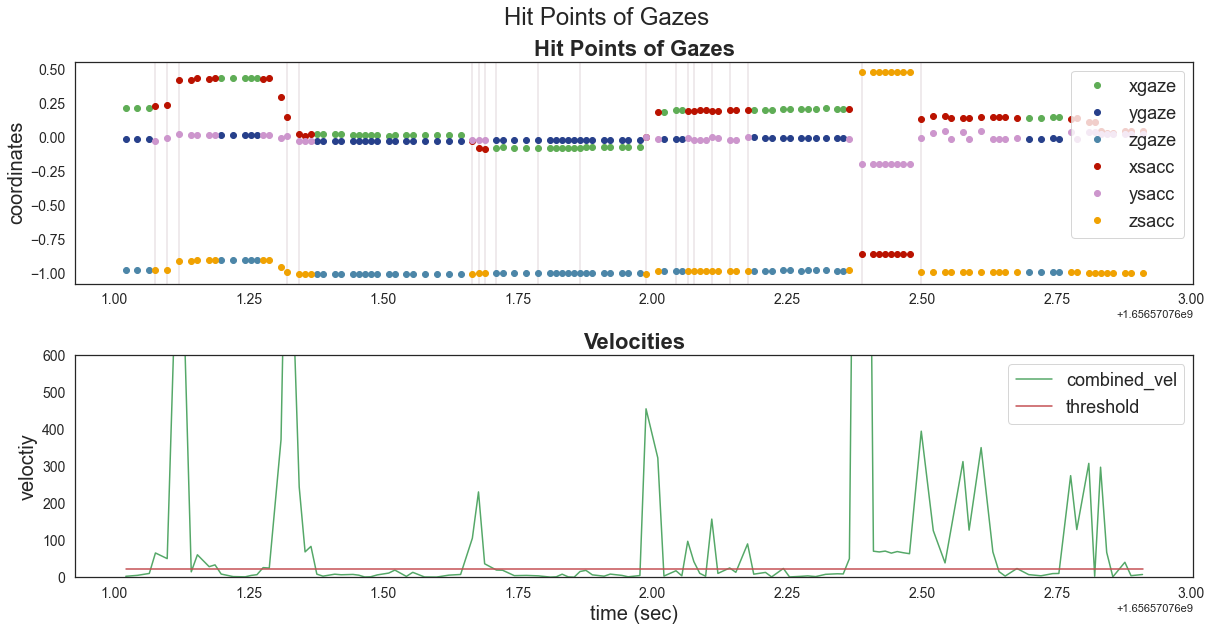

In [24]:
#### Direction Vector
for_eye = pd.read_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/05_Debbies_gaze/One_participant_WDC.csv", index_col="timeStampDataPointEnd")

window_lower = for_eye.index.tolist()[2900]
window_upper = for_eye.index.tolist()[3020]

titel = "Hit Points of Gazes"


# get individual coordinates
 # position
Xcorr_position = for_eye["playerBodyPosition.x"].tolist()
Ycorr_position = for_eye["playerBodyPosition.y"].tolist()
Zcorr_position = for_eye["playerBodyPosition.z"].tolist()
subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

# hpoo
hpooX = for_eye["hitPointOnObject_x"].tolist()
hpooY = for_eye["hitPointOnObject_y"].tolist()
hpooZ = for_eye["hitPointOnObject_z"].tolist()
hpoo = list(zip(hpooX, hpooY, hpooZ))

# v_gaze_vec: get difference in hpoo
v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

# get difference in time:
ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]

# create df to plot
gaze_vec = pd.DataFrame(gaze_vec, columns = ["gvx","gvy","gvz"])
gaze_vec['time'] = for_eye.index.tolist() 
gaze_vec = gaze_vec.set_index('time')
# add it to for_eye so we can differentiate between gaze and saccade
for_eye = pd.concat([for_eye, gaze_vec],axis=1)


# get time:
ts = for_eye.index.tolist()  # to make it easier
time = ts[
    ts.index(
        list(filter(lambda i: i > window_lower, ts))[0]
    ) : ts.index(list(filter(lambda i: i < window_upper, ts))[-1])
    + 1
]  # get all timestamps in the important time window

# get shorter df:
for_eye = for_eye.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)]


# hon: for showing lines in plot
hon = for_eye["Interpolated_collider"].tolist()
new_col = [
    hon[n] if hon[n] != hon[n - 1] and not pd.isnull(hon[n]) else np.nan
    for n in range(len(hon))
]

hon_ts = [
    ti for cnt, ti in enumerate(time) if isinstance(new_col[cnt], str)
]  # timestamps

# get gazes:
gaze = for_eye[~for_eye["isFix"].isnull()]
gaze = gaze.rename({'gvx': 'xgaze', 'gvy': 'ygaze', 'gvz': 'zgaze'}, axis=1)

sacc = for_eye[~for_eye.index.isin(gaze.index)]
sacc = sacc.rename({'gvx': 'xsacc', 'gvy': 'ysacc', 'gvz': 'zsacc'}, axis=1)

# plot it:
sns.set(rc={"figure.figsize": (17, 9)})
sns.set_style(
    "white"
)  # styledict, or one of {darkgrid, whitegrid, dark, white, ticks}

f, (axis) = plt.subplots(2, 1)


for x, xc in enumerate(hon_ts):
    if not np.isnan(xc):
        axis[0].axvline(
            x=xc, color="#987284", alpha=0.2, label="_Hidden label"
        )

color_gaze = {
    "xgaze": "#5FAD56",
    "ygaze": "#27408B",
    "zgaze": "#4C86A8",
}
color_sacc = {
    "xsacc": "#BA1200",
    "ysacc": "#CD96CD",
    "zsacc": "#F0A202",
}

gaze[["xgaze", "ygaze", "zgaze"]].plot(
    color=[
        color_gaze.get(x, "#333333")
        for x in gaze[["xgaze", "ygaze", "zgaze"]]
    ],
    ax=axis[0],
    marker="o",
    ls="",
)

sacc[["xsacc", "ysacc", "zsacc"]].plot(
    color=[
        color_sacc.get(x, "#333333")
        for x in sacc[["xsacc", "ysacc", "zsacc"]]
    ],
    ax=axis[0],
    marker="o",
    ls="",
)

axis[0].set_title(
    titel,
    fontsize=22,
    fontweight='bold',
)
axis[0].legend(loc="upper right", fontsize=18)
axis[0].xaxis.label.set_visible(False)
axis[0].set_ylabel("coordinates", fontsize=20)
axis[0].yaxis.set_tick_params(labelsize = 14) # change tick size
axis[0].xaxis.set_tick_params(labelsize = 14) 



axis[1].plot(time, for_eye["combined_vel"].tolist(), "g", label = "combined_vel")
axis[1].plot(time, for_eye["thresh"].tolist(), "r", label = "threshold")

#axis[3].plot(time, long_events_mad, "k")
## axis[2].plot(time, blinks, "b")  # blinks
axis[1].set_ylim(0, 600)
axis[1].set_title(
        "Velocities",
        fontsize=22,
        fontweight='bold',
    )
axis[1].legend(loc="upper right", fontsize=18)
#plt.xticks(fontsize=14)
#ax.set_xticklabels(time,fontsize=20)
#plt.suptitle(uid, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
axis[1].set_xlabel("time (sec)", fontsize=20)
axis[1].set_ylabel("veloctiy", fontsize=20)
axis[1].yaxis.set_tick_params(labelsize = 14) # change tick size
axis[1].xaxis.set_tick_params(labelsize = 14) 

plt.suptitle(titel, fontsize=24)


In [16]:
for_eye = pd.read_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/03_Debbies_gaze/One_participant_WDC.csv", index_col="timeStampDataPointEnd")

window_lower = for_eye.index.tolist()[2070]
window_upper = for_eye.index.tolist()[2270]

titel = "Hit Points of Gazes"
            

# get time:
ts = for_eye.index.tolist()  # to make it easier
time = ts[
    ts.index(
        list(filter(lambda i: i > window_lower, ts))[0]
    ) : ts.index(list(filter(lambda i: i < window_upper, ts))[-1])
    + 1
]  # get all timestamps in the important time window

# get shorter df:
for_eye = for_eye.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)]


# hon: for showing lines in plot
hon = for_eye["Interpolated_collider"].tolist()
new_col = [
    hon[n] if hon[n] != hon[n - 1] and not pd.isnull(hon[n]) else np.nan
    for n in range(len(hon))
]

hon_ts = [
    ti for cnt, ti in enumerate(time) if isinstance(new_col[cnt], str)
]  # timestamps

# get gazes:
gaze = for_eye[~for_eye["isFix"].isnull()]
gaze = gaze.rename({'hitPointOnObject_x': 'xgaze', 'hitPointOnObject_y': 'ygaze', 'hitPointOnObject_z': 'zgaze'}, axis=1)

sacc = for_eye[~for_eye.index.isin(gaze.index)]
sacc = sacc.rename({'hitPointOnObject_x': 'xsacc', 'hitPointOnObject_y': 'ysacc', 'hitPointOnObject_z': 'zsacc'}, axis=1)


# plot it:
sns.set(rc={"figure.figsize": (17, 9)})
sns.set_style(
    "white"
)  # styledict, or one of {darkgrid, whitegrid, dark, white, ticks}

f, (axis) = plt.subplots(2, 1)


for x, xc in enumerate(hon_ts):
    if not np.isnan(xc):
        axis[0].axvline(
            x=xc, color="#987284", alpha=0.2, label="_Hidden label"
        )

color_gaze = {
    "xgaze": "#5FAD56",
    "ygaze": "#27408B",
    "zgaze": "#4C86A8",
}
color_sacc = {
    "xsacc": "#BA1200",
    "ysacc": "#CD96CD",
    "zsacc": "#F0A202",
}

gaze[["xgaze", "ygaze", "zgaze"]].plot(
    color=[
        color_gaze.get(x, "#333333")
        for x in gaze[["xgaze", "ygaze", "zgaze"]]
    ],
    ax=axis[0],
    marker="o",
    ls="",
)

sacc[["xsacc", "ysacc", "zsacc"]].plot(
    color=[
        color_sacc.get(x, "#333333")
        for x in sacc[["xsacc", "ysacc", "zsacc"]]
    ],
    ax=axis[0],
    marker="o",
    ls="",
)

axis[0].set_title(
    titel,
    fontsize=22,
    fontweight='bold',
)
axis[0].legend(loc="upper right", fontsize=18)
axis[0].xaxis.label.set_visible(False)
axis[0].set_ylabel("coordinates", fontsize=20)
axis[0].yaxis.set_tick_params(labelsize = 14) # change tick size
axis[0].xaxis.set_tick_params(labelsize = 14) 



axis[1].plot(time, for_eye["combined_vel"].tolist(), "g", label = "combined_vel")
axis[1].plot(time, for_eye["thresh"].tolist(), "r", label = "threshold")

#axis[3].plot(time, long_events_mad, "k")
## axis[2].plot(time, blinks, "b")  # blinks
axis[1].set_ylim(0, 600)
axis[1].set_title(
        "Velocities",
        fontsize=22,
        fontweight='bold',
    )
axis[1].legend(loc="upper right", fontsize=18)
#plt.xticks(fontsize=14)
#ax.set_xticklabels(time,fontsize=20)
#plt.suptitle(uid, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
axis[1].set_xlabel("time (sec)", fontsize=20)
axis[1].set_ylabel("veloctiy", fontsize=20)
axis[1].yaxis.set_tick_params(labelsize = 14) # change tick size
axis[1].xaxis.set_tick_params(labelsize = 14) 

plt.suptitle(titel, fontsize=24)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SSD/00_Data_Processing/Pre_processed/03_Debbies_gaze/One_participant_WDC.csv'

In [ ]:
for_eye